# TensorFlow Convolutional Neural Network for Image Classification

In [41]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [42]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
# classes = ['dogs', 'cats']
classes = ['1-', '2', '3+']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

# train_path = '../../data_dogs_vs_cats/train/'
# test_path = '../../data_dogs_vs_cats/test/'
train_path = '../../../../20201020134002/dataset/'
test_path = '../../../../20201020134002/Aria1/'
checkpoint_dir = "models/"

## Load Data

In [43]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading 1- files (Index: 0)
Loading 2 files (Index: 1)
Loading 3+ files (Index: 2)


In [44]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		840
- Validation-set:	160


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [45]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(np.array(image))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

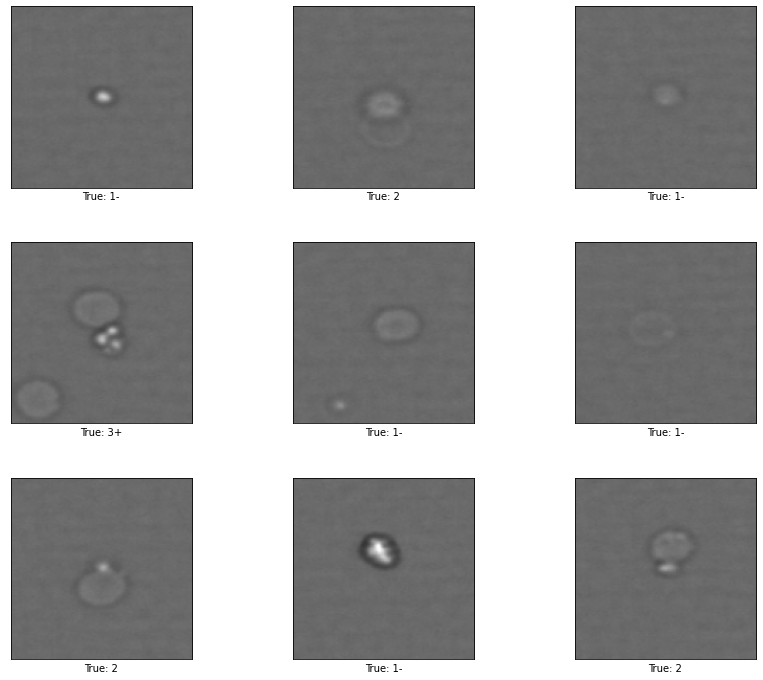

In [46]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

### Model

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(num_filters1, filter_size1, strides = (2, 2), 
                           padding = "SAME", activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04),
                           input_shape=(img_size, img_size, num_channels)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, 
                           padding = "SAME", activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.Conv2D(num_filters2, filter_size2, 
                           padding = "SAME", activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(num_filters3, filter_size3, 
                           padding = "SAME", activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_size, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

## TensorFlow Run

### Helper-function to perform optimization iterations

It takes a long time to calculate the gradient of the model using the entirety of a large dataset
. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [48]:
train_batch_size = batch_size

In [49]:
def print_progress(epoch, train_acc, val_acc, val_loss):
    msg = f"Epoch {epoch} --- Training Accuracy: {train_acc:>6.1%}, Validation Accuracy: {val_acc:>6.1%}, Validation Loss: {val_loss:.3f}"
    print(msg)

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [50]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations, total_iterations + num_iterations):
        # Reset the metric accumulators
        model.reset_metrics()

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        result = model.train_on_batch(x_batch, y_true_batch) 
        train_acc = result[1]

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss, val_acc = model.test_on_batch(x_valid_batch, y_valid_batch, reset_metrics=False)
            epoch = int(i / int(data.train.num_examples/batch_size))
            metrics_names = model.metrics_names
            
            print_progress(epoch, train_acc, val_acc, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [51]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]

    # Plot the first 9 images.
    plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

### Helper-function to plot confusion matrix

In [52]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [53]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = np.argmax(model(images), 1)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)         

## Performance after 1 optimization iteration

In [55]:
train(num_iterations=1)
print_validation_accuracy()

Epoch 0 --- Training Accuracy:   6.2%, Validation Accuracy:  71.9%, Validation Loss: 5.528
Time elapsed: 0:00:01
Accuracy on Test-Set: 70.6% (113 / 160)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [56]:
train(num_iterations=99)  # We already performed 1 iteration above.

Epoch 1 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 4.943
Epoch 2 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 4.596
Epoch 3 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 4.287
Time elapsed: 0:00:15


Accuracy on Test-Set: 70.6% (113 / 160)
Example errors:


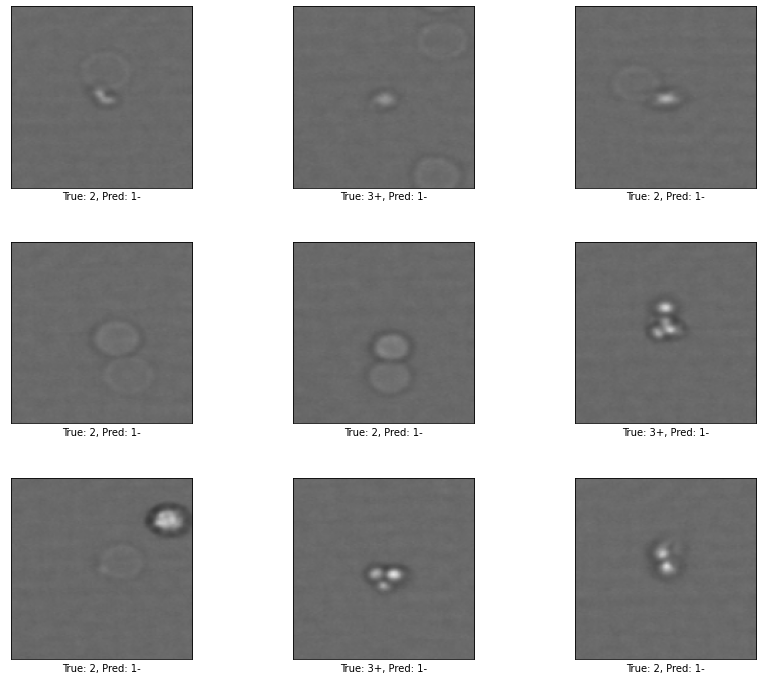

Confusion Matrix:
[[113   0   0]
 [ 33   0   0]
 [ 14   0   0]]


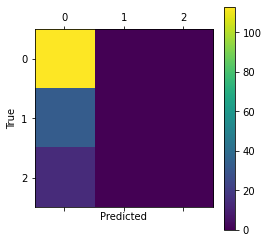

In [57]:
print_validation_accuracy(show_example_errors=True,show_confusion_matrix=True)

## Performance after 1000 optimization iterations

In [58]:
train(num_iterations=900)  # We performed 100 iterations above.

Epoch 4 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 4.083
Epoch 5 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 3.801
Epoch 6 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 3.549
Epoch 7 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 3.308
Epoch 8 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 3.077
Epoch 9 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 2.956
Epoch 10 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 2.764
Epoch 11 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 2.598
Epoch 12 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 2.435
Epoch 13 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 2.274
Epoch 14 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 

Accuracy on Test-Set: 70.6% (113 / 160)
Example errors:


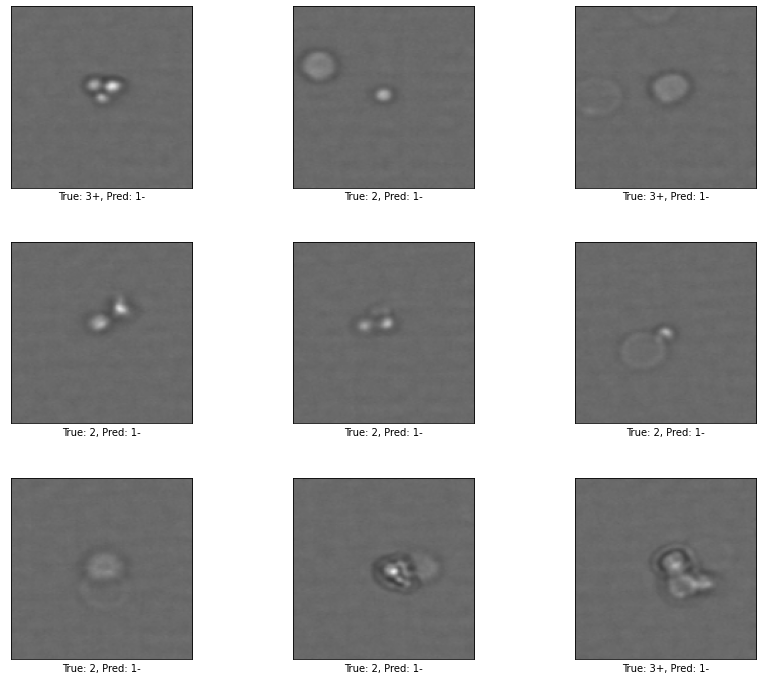

Confusion Matrix:
[[113   0   0]
 [ 33   0   0]
 [ 14   0   0]]


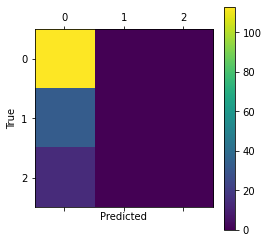

In [59]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Performance after 7,500 optimization iterations

In [60]:
train(num_iterations=6500) # We performed 1000 iterations above.

Epoch 39 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 1.010
Epoch 40 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.972
Epoch 41 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.946
Epoch 42 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.917
Epoch 43 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.880
Epoch 44 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.939
Epoch 45 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.915
Epoch 46 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.900
Epoch 47 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.879
Epoch 48 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.849
Epoch 49 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation 

Epoch 128 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.764
Epoch 129 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.814
Epoch 130 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.798
Epoch 131 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.794
Epoch 132 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.783
Epoch 133 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.764
Epoch 134 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.802
Epoch 135 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.789
Epoch 136 --- Training Accuracy:  65.6%, Validation Accuracy:  68.8%, Validation Loss: 0.785
Epoch 137 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, Validation Loss: 0.785
Epoch 138 --- Training Accuracy:  65.6%, Validation Accuracy:  71.9%, 

Epoch 217 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 0.759
Epoch 218 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.745
Epoch 219 --- Training Accuracy:  68.8%, Validation Accuracy:  71.9%, Validation Loss: 0.686
Epoch 220 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.722
Epoch 221 --- Training Accuracy:  68.8%, Validation Accuracy:  71.9%, Validation Loss: 0.735
Epoch 222 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 0.752
Epoch 223 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.741
Epoch 224 --- Training Accuracy:  68.8%, Validation Accuracy:  71.9%, Validation Loss: 0.679
Epoch 225 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.733
Epoch 226 --- Training Accuracy:  68.8%, Validation Accuracy:  71.9%, Validation Loss: 0.737
Epoch 227 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, 

Accuracy on Test-Set: 73.1% (117 / 160)
Example errors:


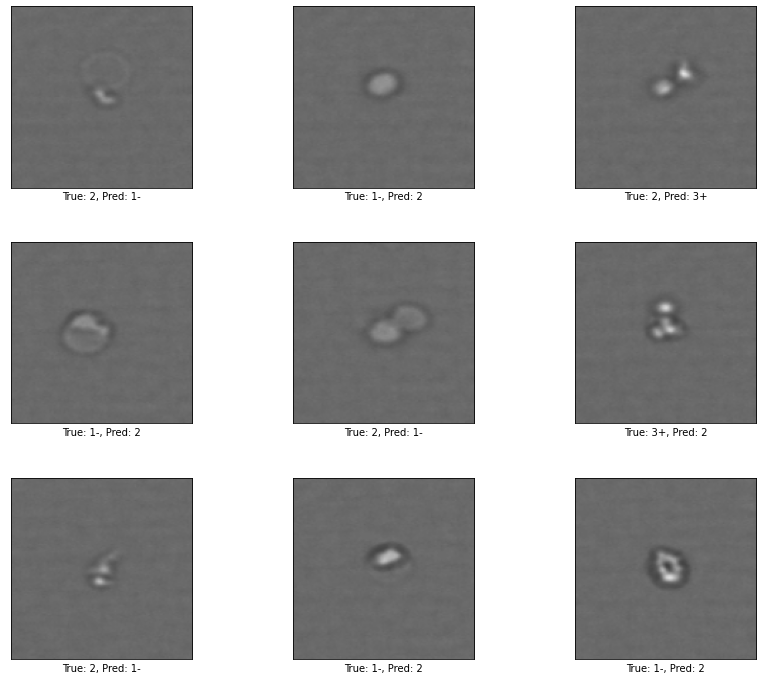

Confusion Matrix:
[[102  10   1]
 [ 22   8   3]
 [  3   4   7]]


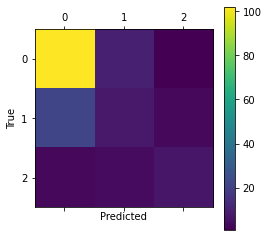

In [61]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [62]:
# for small dataset (800), additional iterations are not improving the classification anymore
# overfitting occurs instead (cause validation accuracy to drop, loss to rise)
train(num_iterations=2500)

Epoch 289 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.693
Epoch 290 --- Training Accuracy:  68.8%, Validation Accuracy:  71.9%, Validation Loss: 0.740
Epoch 291 --- Training Accuracy:  68.8%, Validation Accuracy:  78.1%, Validation Loss: 0.738
Epoch 292 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 0.710
Epoch 293 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.707
Epoch 294 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.663
Epoch 295 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.705
Epoch 296 --- Training Accuracy:  68.8%, Validation Accuracy:  78.1%, Validation Loss: 0.737
Epoch 297 --- Training Accuracy:  68.8%, Validation Accuracy:  65.6%, Validation Loss: 0.700
Epoch 298 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.696
Epoch 299 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, 

Epoch 378 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 0.664
Epoch 379 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.687
Epoch 380 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.677
Epoch 381 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.732
Epoch 382 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 0.647
Epoch 383 --- Training Accuracy:  71.9%, Validation Accuracy:  68.8%, Validation Loss: 0.662
Epoch 384 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.691
Time elapsed: 0:06:52


Accuracy on Test-Set: 76.2% (122 / 160)
Example errors:


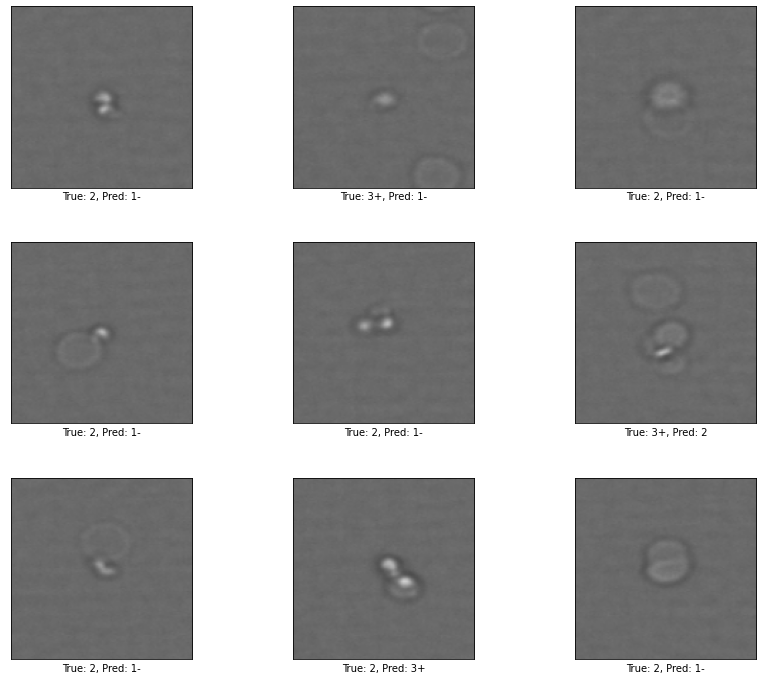

Confusion Matrix:
[[106   7   0]
 [ 21  10   2]
 [  2   6   6]]


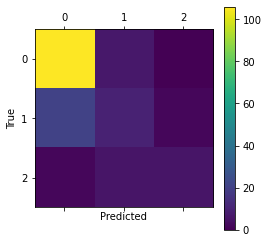

In [63]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Epoch 385 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.704
Epoch 386 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.727
Epoch 387 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.678
Epoch 388 --- Training Accuracy:  75.0%, Validation Accuracy:  75.0%, Validation Loss: 0.685
Epoch 389 --- Training Accuracy:  71.9%, Validation Accuracy:  78.1%, Validation Loss: 0.762
Epoch 390 --- Training Accuracy:  75.0%, Validation Accuracy:  78.1%, Validation Loss: 0.632
Epoch 391 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, Validation Loss: 0.812
Epoch 392 --- Training Accuracy:  75.0%, Validation Accuracy:  71.9%, Validation Loss: 0.613
Epoch 393 --- Training Accuracy:  68.8%, Validation Accuracy:  68.8%, Validation Loss: 0.682
Epoch 394 --- Training Accuracy:  71.9%, Validation Accuracy:  75.0%, Validation Loss: 0.695
Epoch 395 --- Training Accuracy:  68.8%, Validation Accuracy:  75.0%, 

Epoch 474 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.726
Epoch 475 --- Training Accuracy:  81.2%, Validation Accuracy:  78.1%, Validation Loss: 0.597
Epoch 476 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.699
Epoch 477 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.610
Epoch 478 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.652
Epoch 479 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.732
Epoch 480 --- Training Accuracy:  78.1%, Validation Accuracy:  78.1%, Validation Loss: 0.604
Epoch 481 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.703
Epoch 482 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.612
Epoch 483 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, Validation Loss: 0.652
Epoch 484 --- Training Accuracy:  81.2%, Validation Accuracy:  75.0%, 

Epoch 563 --- Training Accuracy:  84.4%, Validation Accuracy:  71.9%, Validation Loss: 0.642
Epoch 564 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.720
Epoch 565 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.488
Epoch 566 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.715
Epoch 567 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.608
Epoch 568 --- Training Accuracy:  84.4%, Validation Accuracy:  78.1%, Validation Loss: 0.633
Epoch 569 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.720
Epoch 570 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.478
Epoch 571 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, Validation Loss: 0.706
Epoch 572 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.611
Epoch 573 --- Training Accuracy:  84.4%, Validation Accuracy:  75.0%, 

Epoch 652 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.611
Epoch 653 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.582
Epoch 654 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.674
Epoch 655 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.413
Epoch 656 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.699
Epoch 657 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.611
Epoch 658 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.576
Epoch 659 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.685
Epoch 660 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.419
Epoch 661 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.738
Epoch 662 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%, 

Epoch 741 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.748
Epoch 742 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.626
Epoch 743 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.535
Epoch 744 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.711
Epoch 745 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.400
Epoch 746 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.767
Epoch 747 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.629
Epoch 748 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.532
Epoch 749 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.711
Epoch 750 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.404
Epoch 751 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, 

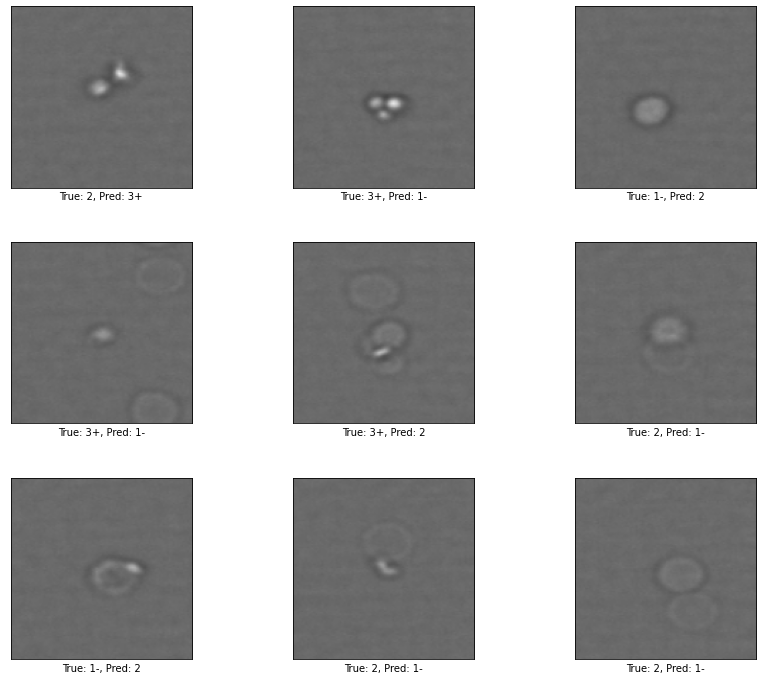

Confusion Matrix:
[[109   4   0]
 [ 16  14   3]
 [  4   4   6]]


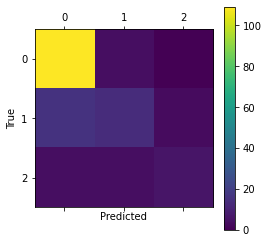

In [64]:
train(num_iterations=10000)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Epoch 770 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.384
Epoch 771 --- Training Accuracy:  87.5%, Validation Accuracy:  75.0%, Validation Loss: 0.844
Epoch 772 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.639
Epoch 773 --- Training Accuracy:  87.5%, Validation Accuracy:  84.4%, Validation Loss: 0.526
Epoch 774 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.708
Epoch 775 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.383
Epoch 776 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.783
Epoch 777 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.629
Epoch 778 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.523
Epoch 779 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.707
Epoch 780 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, 

Epoch 859 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.765
Epoch 860 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.393
Epoch 861 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.850
Epoch 862 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.644
Epoch 863 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.519
Epoch 864 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.686
Epoch 865 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.383
Epoch 866 --- Training Accuracy:  90.6%, Validation Accuracy:  75.0%, Validation Loss: 0.908
Epoch 867 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.652
Epoch 868 --- Training Accuracy:  90.6%, Validation Accuracy:  84.4%, Validation Loss: 0.520
Epoch 869 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, 

Epoch 948 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.548
Epoch 949 --- Training Accuracy:  93.8%, Validation Accuracy:  78.1%, Validation Loss: 0.762
Epoch 950 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.432
Epoch 951 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 1.127
Epoch 952 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.701
Epoch 953 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.538
Epoch 954 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.733
Epoch 955 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, Validation Loss: 0.429
Epoch 956 --- Training Accuracy:  93.8%, Validation Accuracy:  75.0%, Validation Loss: 1.129
Epoch 957 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0.675
Epoch 958 --- Training Accuracy:  93.8%, Validation Accuracy:  81.2%, 

Epoch 1036 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 1.276
Epoch 1037 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.666
Epoch 1038 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.574
Epoch 1039 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.769
Epoch 1040 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.455
Epoch 1041 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.242
Epoch 1042 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.644
Epoch 1043 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.565
Epoch 1044 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.728
Epoch 1045 --- Training Accuracy:  96.9%, Validation Accuracy:  84.4%, Validation Loss: 0.444
Epoch 1046 --- Training Accuracy:  96.9%, Validation Accurac

Epoch 1124 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.795
Epoch 1125 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.488
Epoch 1126 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.477
Epoch 1127 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.613
Epoch 1128 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.590
Epoch 1129 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.737
Epoch 1130 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.447
Epoch 1131 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.457
Epoch 1132 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.657
Epoch 1133 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.617
Epoch 1134 --- Training Accuracy:  96.9%, Validation Accurac

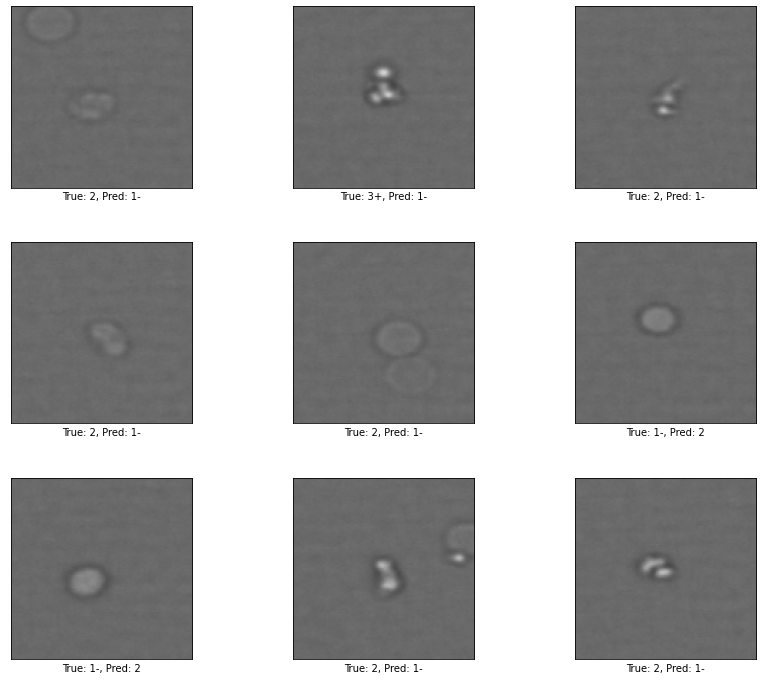

Confusion Matrix:
[[109   4   0]
 [ 17  13   3]
 [  1   4   9]]


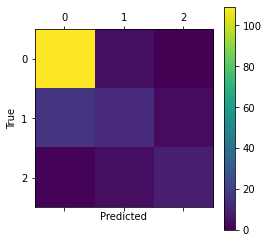

In [65]:
train(num_iterations=10000)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

Epoch 1154 --- Training Accuracy:  96.9%, Validation Accuracy:  81.2%, Validation Loss: 0.791
Epoch 1155 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.478
Epoch 1156 --- Training Accuracy:  96.9%, Validation Accuracy:  75.0%, Validation Loss: 1.496
Epoch 1157 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.636
Epoch 1158 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.587
Epoch 1159 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.723
Epoch 1160 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.469
Epoch 1161 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.468
Epoch 1162 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.618
Epoch 1163 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.579
Epoch 1164 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 1242 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.602
Epoch 1243 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.624
Epoch 1244 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.789
Epoch 1245 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.479
Epoch 1246 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.646
Epoch 1247 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.601
Epoch 1248 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.641
Epoch 1249 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.798
Epoch 1250 --- Training Accuracy:  96.9%, Validation Accuracy:  87.5%, Validation Loss: 0.535
Epoch 1251 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.732
Epoch 1252 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 1330 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.540
Epoch 1331 --- Training Accuracy: 100.0%, Validation Accuracy:  75.0%, Validation Loss: 1.933
Epoch 1332 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.675
Epoch 1333 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.714
Epoch 1334 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.830
Epoch 1335 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.522
Epoch 1336 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 1.890
Epoch 1337 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.657
Epoch 1338 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.725
Epoch 1339 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.884
Epoch 1340 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 1418 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.778
Epoch 1419 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.927
Epoch 1420 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.623
Epoch 1421 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.118
Epoch 1422 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.634
Epoch 1423 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.750
Epoch 1424 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.862
Epoch 1425 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.572
Epoch 1426 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.109
Epoch 1427 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.665
Epoch 1428 --- Training Accuracy: 100.0%, Validation Accurac

Epoch 1506 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.300
Epoch 1507 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.655
Epoch 1508 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.804
Epoch 1509 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.883
Epoch 1510 --- Training Accuracy: 100.0%, Validation Accuracy:  90.6%, Validation Loss: 0.598
Epoch 1511 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 2.310
Epoch 1512 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.686
Epoch 1513 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.894
Epoch 1514 --- Training Accuracy: 100.0%, Validation Accuracy:  81.2%, Validation Loss: 0.994
Epoch 1515 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.647
Epoch 1516 --- Training Accuracy: 100.0%, Validation Accurac

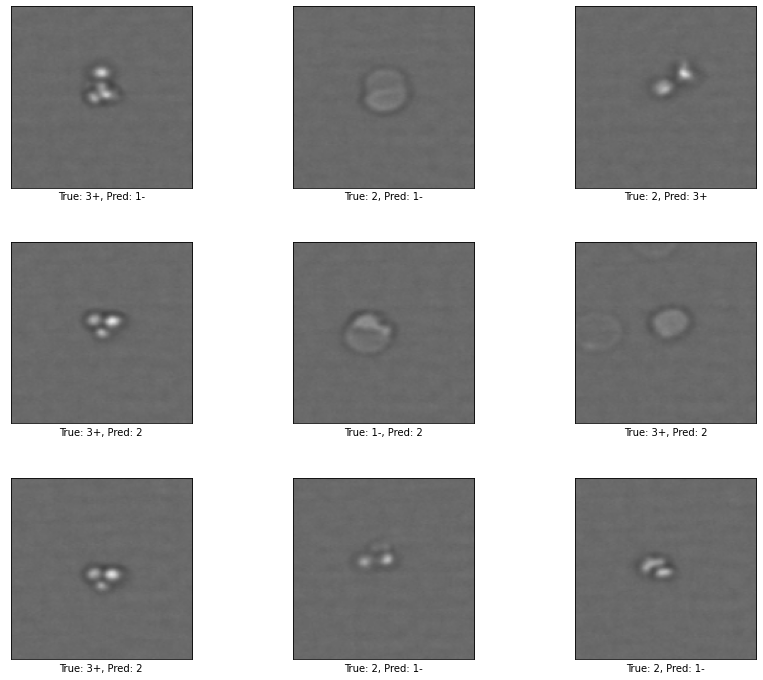

Confusion Matrix:
[[108   5   0]
 [ 12  19   2]
 [  1   4   9]]


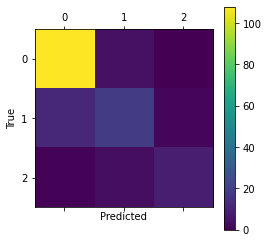

In [66]:
train(num_iterations=10000)
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Test on Sample Image

In [67]:
# plt.axis('off')

# test_cat = cv2.imread('cat.jpg')

# plt.imshow(cv2.cvtColor(test_cat, cv2.COLOR_BGR2RGB))
# plt.show()

In [68]:
# test_dog = cv2.imread('dog.jpg')

# plt.imshow(cv2.cvtColor(test_dog, cv2.COLOR_BGR2RGB))
# plt.show()

In [69]:
# def sample_prediction(test_im):
#     test_im = cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR) / 255
#     test_pred = np.argmax(model(test_im.reshape((1, img_size, img_size, 3))))
#     return classes[test_pred]

# print("Predicted class for test_cat: {}".format(sample_prediction(test_cat)))
# print("Predicted class for test_dog: {}".format(sample_prediction(test_dog)))